In [1]:
# Import libraries
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot

2025-07-25 18:39:21.651326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753468761.933770      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753468762.014448      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set your correct dataset directory
dataset_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'


In [3]:
# Define the image dimensions
img_height, img_width = 224, 224

In [4]:

# Load and preprocess the data
def load_data(dataset_dir):
    images = []
    labels = []

    # List the main folders
    main_folders = ['colon_image_sets', 'lung_image_sets']

    for main_folder in main_folders:
        main_path = os.path.join(dataset_dir, main_folder)
        for folder in os.listdir(main_path):
            label = folder
            folder_path = os.path.join(main_path, folder)
            for filename in os.listdir(folder_path):
                img = cv2.imread(os.path.join(folder_path, filename))
                img = cv2.resize(img, (img_height, img_width))
                images.append(img)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    
images, labels = load_data(dataset_dir)

In [5]:
# Encode labels (Map class names to numbers)
label_dict = {
    'colon_aca': 0, 
    'colon_n': 1, 
    'lung_aca': 2, 
    'lung_n': 3, 
    'lung_scc': 4
}
labels = np.array([label_dict[label] for label in labels])
labels = to_categorical(labels)

In [6]:
# Split the data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

I0000 00:00:1753469053.127064      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Add custom top layers for classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes
])

In [9]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    verbose=1,
    patience=3,         # Stop if no improvement for 3 epochs
    restore_best_weights=True  # Restore best model weights
)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [11]:
# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_reduce]  
)

Epoch 1/200


I0000 00:00:1753469099.112590      59 service.cc:148] XLA service 0x7eb62c0025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753469099.113537      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753469102.533592      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753469108.327364      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753469108.524651      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/547 ━━━━━━━━━━━━━━━━━━━━ 8:34:32 57s/step - accuracy: 0.1250 - loss: 2.1672

I0000 00:00:1753469119.004679      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9112 - loss: 0.2696

E0000 00:00:1753469165.648186      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753469165.847563      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


547/547 ━━━━━━━━━━━━━━━━━━━━ 124s 123ms/step - accuracy: 0.9113 - loss: 0.2692 - val_accuracy: 0.2424 - val_loss: 26.1307 - learning_rate: 0.0010
Epoch 2/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9700 - loss: 0.0910 - val_accuracy: 0.1952 - val_loss: 31.4129 - learning_rate: 0.0010
Epoch 3/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9836 - loss: 0.0470 - val_accuracy: 0.1979 - val_loss: 31.4554 - learning_rate: 0.0010
Epoch 4/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9876 - loss: 0.0361 - val_accuracy: 0.3787 - val_loss: 14.2017 - learning_rate: 2.0000e-04
Epoch 5/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9956 - loss: 0.0125 - val_accuracy: 0.9040 - val_loss: 0.5843 - learning_rate: 2.0000e-04
Epoch 6/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9975 - loss: 0.0068 - val_accuracy: 0.9907 - val_loss: 0.0268 - learning_rate: 2.0000e-04
Epoch 7/200
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accurac

In [12]:
# After training the model, evaluate on all datasets
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [13]:
# Print the accuracies
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Training Accuracy: 1.0000
Validation Accuracy: 0.9992
Test Accuracy: 0.9997



Training Accuracy: 1.0000
Validation Accuracy: 0.9992
Test Accuracy: 0.9997


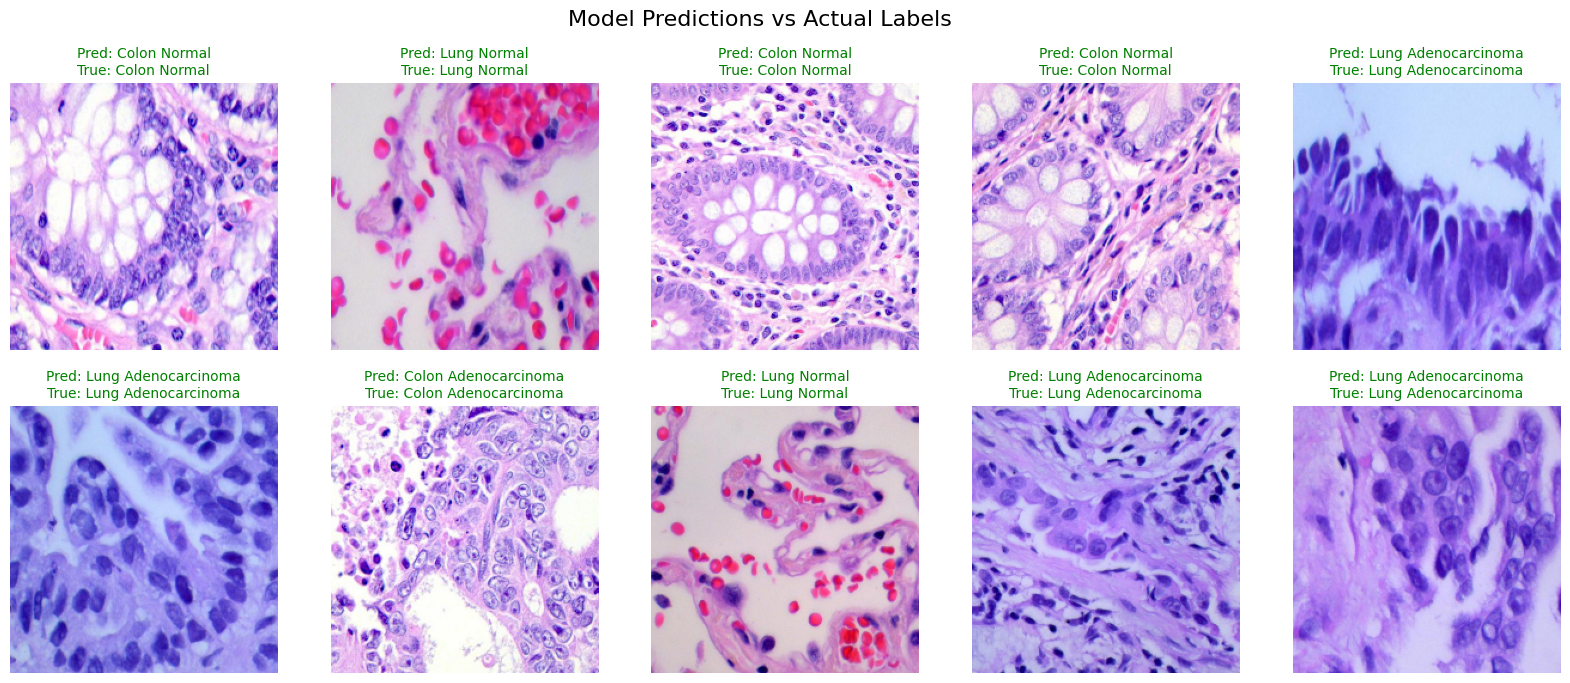

In [14]:
# Print the accuracies
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Visualization of predictions
import matplotlib.pyplot as plt
import random

# Define class names
class_names = [
    "Colon Adenocarcinoma",
    "Colon Normal",
    "Lung Adenocarcinoma",
    "Lung Normal",
    "Lung Squamous Cell Carcinoma"
]

# Convert one-hot encoded labels back to class indices
y_test_indices = np.argmax(y_test, axis=1)

# Randomly select 10 test samples
indices = random.sample(range(len(X_test)), 10)

# Create plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Model Predictions vs Actual Labels', fontsize=16, y=0.94)  # Increased y-position

for i, idx in enumerate(indices):
    ax = axes[i//5, i%5]
    
    # Get image and convert BGR to RGB for display
    image = cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB)
    true_label_idx = y_test_indices[idx]
    
    # Make prediction
    pred = model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0)
    pred_label_idx = np.argmax(pred)
    
    # Display image
    ax.imshow(image)
    ax.axis('off')
    
    # Set title color based on prediction correctness
    title_color = 'green' if pred_label_idx == true_label_idx else 'red'
    ax.set_title(
        f"Pred: {class_names[pred_label_idx]}\nTrue: {class_names[true_label_idx]}",
        color=title_color,
        fontsize=10
    )

# Add more vertical space above the subplots
plt.subplots_adjust(top=0.85)  # Reduced from 0.92 to create more space
plt.show()